# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Install Pacakges</div>

In [1]:
!pip install datasets lxml TinyImageNet --quiet

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Import Libraries</div>

In [2]:
import copy
import csv
import gc
import logging
import os
import os.path
import random
import tarfile
import warnings
from collections import OrderedDict
from datetime import datetime
from functools import partial
from math import sqrt
from typing import Callable, List, Optional

import matplotlib.pyplot as plt
import numpy as np
import PIL
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from numba import cuda
from PIL import Image
from scipy.spatial.distance import cosine, euclidean, jensenshannon
from scipy.stats import wasserstein_distance
from sklearn.cluster import AffinityPropagation
from tinyimagenet import TinyImageNet
from torch import nn
from torch.autograd import Variable
from torch.utils.model_zoo import tqdm
from torchvision.datasets import (CIFAR10, CIFAR100, MNIST, SVHN, STL10,
                                  DatasetFolder, FashionMNIST, ImageFolder)
from torchvision.datasets.utils import (check_integrity,
                                        download_file_from_google_drive)
from torchvision.datasets.vision import VisionDataset
from torchvision.transforms import Normalize

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Garbage Collection</div>

In [3]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


def print_gpu_memory():
    print(f"Allocated memory: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Cached memory: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")


print("before memory cleaning:\n")
print_gpu_memory()

gc.collect()
torch.cuda.empty_cache()

cuda.select_device(0)
cuda.close()

print("after memory cleaning:\n")
print_gpu_memory()

# ----------- manually clear memory in case of any error
#!sudo fuser -v /dev/nvidia* or nvidia-smi
# remove all python process ids from gpu
#!sudo kill -9 PID.

before memory cleaning:

Allocated memory: 0.00 MB
Cached memory: 0.00 MB
after memory cleaning:

Allocated memory: 0.00 MB
Cached memory: 0.00 MB


# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Make Directories</div>

In [4]:
!mkdir models
!mkdir models/before_aggregation

In [5]:
log_path = datetime.now().strftime("%Y-%m-%d_%H")
log_file = log_path + ".log"
open(log_file, "a").close()

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Configs</div>

In [6]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
sns.set_theme(
    style="darkgrid", font_scale=1.5, font="SimHei", rc={"axes.unicode_minus": False}
)
warnings.filterwarnings("ignore")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [7]:
CLUSTER_NUMBER = 3              # Number of clusters
CLUSTERING_PERIOD = 5           # Set to `1` to run simple Federated Learning with out clustering
FEDERATED_LEARNING_ROUNDS = 6   # The round in with Federated Learning will be executed
"""
|MODEL_TYPE |  DATASET_TYPE    | NUMBER_OF_CLASSES| PARTITION      | ROUND_EPOCHS|
|-----------|------------------|------------------|----------------|-------------|
|cnn        |  fmnist          | 10               | noniid-#label2 | 1           |
|resnet18   |  cifar10         | 10               | noniid-#label2 | 1           |
|mobilenet  |  svhn            | 10               | noniid-#label2 | 1           |
|vgg16      |  stl10           | 10               | noniid-#label2 | ?           |
|alexnet    |  tinyimagenet    | 200              | noniid-#label10| 10          |
|-----------|------------------|------------------|----------------|-------------|
"""
MODEL_TYPE = "resnet18"
DATASET_TYPE = "cifar10"
# by default set to 0.001 and for AlexNet set to 0.0001
LEARNING_RATE = 0.001          
NUMBER_OF_CLASSES = 10
NUMBER_OF_CLIENTS = 10
# the second part accepted format is: "labeldir" (Dirichlet) or "#label20"
PARTITION = "noniid-" + "#label2" 
# set to 10 for AlexNet
ROUND_EPOCHS = 1
SENSITIVITY_PERCENTAGE = 0.1
"""
DISTANCE_METRIC values are:
- coordinate
- cosine
- euclidean
- jensen-shannon
- wasserstein
"""
DISTANCE_METRIC = "euclidean"

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Model Network</div>

In [8]:
class Net(nn.Module):
    def __init__(
        self,
    ):
        super(Net, self).__init__()

        if MODEL_TYPE == "resnet18":
            self.resnet18 = models.resnet18(pretrained=False)
            if DATASET_TYPE == "mnist":
                self.resnet18.conv1 = nn.Conv2d(
                    1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
                )
            self.resnet18.fc = nn.Linear(
                self.resnet18.fc.in_features, NUMBER_OF_CLASSES
            )

        elif MODEL_TYPE == "cnn":
            self.conv1 = nn.Conv2d(3, 6, 5)
            self.pool = nn.MaxPool2d(2, 2)
            self.conv2 = nn.Conv2d(6, 16, 5)
            self.fc1 = nn.Linear(16 * 5 * 5, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)

        elif MODEL_TYPE == "mobilenet":
            self.mobilenet = models.mobilenet_v2(pretrained=False)
            self.mobilenet.classifier[1] = nn.Linear(
                self.mobilenet.last_channel, NUMBER_OF_CLASSES
            )

        elif MODEL_TYPE == "vgg16":
            self.vgg16 = models.vgg16(pretrained=False)
            self.vgg16.classifier[6] = nn.Linear(
                self.vgg16.classifier[6].in_features, NUMBER_OF_CLASSES
            )

        elif MODEL_TYPE == "alexnet":
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(64, 192, kernel_size=5, padding=2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
                nn.Conv2d(192, 384, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(384, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2),
            )
            self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
            self.classifier = nn.Sequential(
                nn.Dropout(),
                nn.Linear(256 * 6 * 6, 1024),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(1024, 512),
                nn.ReLU(inplace=True),
                nn.Linear(512, NUMBER_OF_CLASSES),
            )

    def forward(self, x):
        out = None

        if MODEL_TYPE == "resnet18":
            out = self.resnet18(x)
        elif MODEL_TYPE == "cnn":
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(x.size(0), 16 * 5 * 5)
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = self.fc3(x)
            out = x

        elif MODEL_TYPE == "mobilenet":
            out = self.mobilenet(x)

        elif MODEL_TYPE == "vgg16":
            out = self.vgg16(x)

        elif MODEL_TYPE == "alexnet":
            x = self.features(x)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.classifier(x)
            out = x

        return out

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Learning</div>

In [9]:
def calculate_accuracy(loader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total


def train(net, node_id, train_loader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr=LEARNING_RATE,
        betas=(0.9, 0.999),
        eps=1e-7,
        weight_decay=1e-4,
    )
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
    loss /= len(train_loader.dataset)
    acc = correct / total
    # ! CEMENTED‌ TO‌ SAVE‌ DISK‌SPACE
    # model_path = f"models/node_{node_id}.pth"
    # torch.save(net.state_dict(), model_path)
    return acc, loss


def test(net, test_loader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(test_loader.dataset)
    accuracy = correct / total
    return accuracy, loss

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Client</div>

In [10]:
class Client:
    def __init__(self, net, node_id, train_loader, test_loader):
        self.net = net.to(DEVICE)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.node_id = node_id
        self.train_acc, self.test_acc = 0.0, 0.0
        self.global_net = Net().to(DEVICE)

    def set_bias(self, pref, bias):
        self.bias = bias
        self.pref = pref

    def set_shard(self, shard):
        self.shard = shard

    def get_global_net(self):
        return self.global_net

    def setting_parameters(self, parameters: List[np.ndarray]):
        params_dict = zip(self.net.state_dict().items(), parameters)
        state_dict = OrderedDict(
            {k: torch.Tensor(v).to(DEVICE) for k, v in params_dict}
        )
        self.net.load_state_dict(state_dict, strict=True)

    def getting_parameters(self) -> List[np.ndarray]:
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    def fit(self, parameters):
        self.setting_parameters(parameters)
        train(self.net, self.node_id, self.train_loader, epochs=ROUND_EPOCHS)
        return self.getting_parameters(), len(self.train_loader), {}

    def evaluate(self, parameters):
        self.setting_parameters(parameters)
        loss, accuracy = test(self.net, self.test_loader)
        return float(loss), len(self.test_loader), {"accuracy": float(accuracy)}

    def Train_test_and_return_acc(self):
        self.train_acc, _ = train(self.net, self.node_id, self.train_loader, ROUND_EPOCHS)
        self.test_acc, _ = test(self.net, self.test_loader)
        return self.train_acc, self.test_acc

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Server</div>

In [11]:
def divide_nested_list(nested_list, divisor):
    for i in range(len(nested_list)):
        if isinstance(nested_list[i], list):
            divide_nested_list(nested_list[i], divisor)
        else:
            nested_list[i] /= divisor
    return nested_list


def zero_nested_list(nested_list):
    for i in range(len(nested_list)):
        if isinstance(nested_list[i], list):
            zero_nested_list(nested_list[i])
        else:
            nested_list[i] = 0
    return nested_list

In [12]:
class Server:
    def __init__(self):
        self.models = []

    def append_model(self, model: nn.Module):
        if not isinstance(model, nn.Module):
            raise TypeError("Only instances of nn.Module can be appended")
        self.models.append(model)

    def aggregate(self):
        if not self.models:
            raise ValueError("No models added to the server.")
        print("model numbers:", len(self.models))
        device = next(self.models[0].parameters()).device
        for model in self.models:
            model.to(device)
        avg_model = Net().to(device)
        with torch.no_grad():
            for param_name, avg_param in avg_model.named_parameters():
                temp = torch.zeros_like(avg_param)
                for model in self.models:
                    model_param = dict(model.named_parameters())[param_name]
                    temp += model_param.data
                avg_param.copy_(temp / len(self.models))
        return avg_model

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Clustering</div>

In [13]:
def find_num_cluster(clusters):
    num_cluster = []
    for item in clusters:
        if item not in num_cluster:
            num_cluster.append(item)
    return len(num_cluster)


class Clustering:
    def __init__(self, clients, trainLoaders, percentage, Cluster_number):
        self.clients = clients
        self.num_nodes = len(clients)
        self.percentage = percentage
        self.Mask_Number = 0
        self.maskIds = []
        self.grads = []
        self.load_and_calculate_sensitivity(trainLoaders)
        self.Cluster_number = Cluster_number
        self.distances = self.calculate_distance()
        self.Clusters = self.make_clusters()

    def assign_save_ids_to_weights(self, model):
        weight_id_map = {}
        weight_id = 0
        for name, parameter in model.named_parameters():
            weight_id_map[name] = {}
            num_weights = parameter.numel()
            for i in range(num_weights):
                weight_id_map[name][i] = weight_id
                weight_id += 1
        filename = "weight_to_id.csv"
        if not os.path.exists(filename):
            with open(filename, "w", newline="") as csvfile:
                writer = csv.writer(csvfile)
                writer.writerow(["Layer", "Weight Index", "Weight ID"])
                for layer_name, indices in weight_id_map.items():
                    for index, weight_id in indices.items():
                        writer.writerow([layer_name, index, weight_id])
        return weight_id_map

    def load_and_calculate_sensitivity(self, trainLoaders):
        """
        Calculate sensitivity for each client and store the results in the object.
        """
        for cid in self.clients:
            model = load_torch_model(cid).to(DEVICE)
            sensitivity_value = self.calculate_sensitivity(
                model, trainLoaders[int(cid)]
            )
            weight_id_map = self.assign_save_ids_to_weights(
                load_torch_model(0).to(DEVICE)
            )
            
            mask_ID, weights = self.get_maskIds(sensitivity_value, weight_id_map, self.percentage)   # top sensitive weights will filter here
            print(f"Model weights and sensitivity data for client #{cid} processed.")

            self.maskIds.append(mask_ID)
            self.grads.append(weights)

    def calculate_sensitivity(self, model, dataloader):
        model.train()
        criterion = nn.CrossEntropyLoss()
        gradient_sums = {}
        for name, param in model.named_parameters():
            gradient_sums[name] = 0.0
            param.requires_grad_(True)
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # Backward pass
            model.zero_grad()
            loss.backward()
            sensitivities = {}
            for name, parameter in model.named_parameters():
                grads = parameter.grad.abs().view(-1).cpu().numpy()
                for i, grad in enumerate(grads):
                    sensitivities[(name, i)] = grad
            return sensitivities

    def get_maskIds(self, sensitivity_values_node, weight_id_map, sensitive_percentage):
        num_weights = len(sensitivity_values_node)
        top_k = int(np.ceil(sensitive_percentage * num_weights / 100))
        self.Mask_Number = top_k
        sorted_weights = sorted(
            sensitivity_values_node.items(), key=lambda item: item[1], reverse=True
        )[:top_k]
        weights = [weight for (layer, index), weight in sensitivity_values_node.items()]
        top_weight_ids = [
            weight_id_map[layer][index] for (layer, index), _ in sorted_weights
        ]
        return top_weight_ids, weights

    def normalize(self, distances, sensitive):
        normal_distances = np.zeros((self.num_nodes, self.num_nodes))
        for i in range(self.num_nodes):
            normal_distances[i][i] = 0
            for j in range(i + 1, self.num_nodes):
                normal_distances[i][j] = normal_distances[j][i] = distances[i][j] / len(
                    sensitive
                )
        return normal_distances

    def calculate_common_ids(self, index1, index2):
        arr1 = self.maskIds[index1]
        arr2 = self.maskIds[index2]
        sarr1 = set(arr1)
        sarr2 = set(arr2)
        inter = sarr1.intersection(sarr2)
        similarity1 = len(inter)
        return similarity1

    def calculate_distance(
        self,
    ):
        similarity_matrix = np.zeros((self.num_nodes, self.num_nodes))
        
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                
                if DISTANCE_METRIC == "coordinate":
                    similarity = self.calculate_common_ids(i, j)
                elif DISTANCE_METRIC == "cosine":
                    # Cosine distance
                    similarity = 1 - cosine(self.grads[i], self.grads[j])
                elif DISTANCE_METRIC == "euclidean":
                    # Euclidean distance
                    similarity = -euclidean(self.grads[i], self.grads[j])  # Negative for clustering
                elif DISTANCE_METRIC == "jensen-shannon":
                    # Jensen-Shannon divergence
                    similarity = -jensenshannon(self.grads[i], self.grads[j])  # Negative for clustering
                elif DISTANCE_METRIC == "wasserstein":
                    # Wasserstein distance
                    similarity = -wasserstein_distance(self.grads[i], self.grads[j])  # Negative for clustering
                else:
                    raise ValueError(f"Unsupported distance metric: {DISTANCE_METRIC}")
                similarity_matrix[i, j] = similarity
                similarity_matrix[j, i] = similarity
            similarity_matrix[i, i] = self.Mask_Number
        distances = self.Mask_Number - similarity_matrix
        
        self.save_distances_to_csv(distances)
        
        return distances

    def index_to_value(self, groups):
        value_groups = []
        for group in groups:
            list1 = []
            for index in group:
                list1.append(self.clients[index])
            value_groups.append(list1)
        return value_groups

    def make_clusters(self):
        normal_distances = (self.distances + self.distances.T) / 2
        np.fill_diagonal(normal_distances, 0)
        affinity_propagation = AffinityPropagation(affinity="precomputed")
        normal_distances = -normal_distances
        clusters = affinity_propagation.fit_predict(normal_distances)
        print(f"cluster results:{clusters}")
        # Find the maximum cluster label from the assigned labels
        max_label = max(clusters)
        # Assign unique positive labels to noise points (initially labeled as -1)
        noise_indices = clusters == -1
        unique_noise_labels = np.arange(
            max_label + 1, max_label + 1 + np.sum(noise_indices)
        )
        clusters[noise_indices] = unique_noise_labels
        cluster_list = [
            np.where(clusters == cluster_id)[0].tolist()
            for cluster_id in range(find_num_cluster(clusters))
        ]
        cluster_list = self.index_to_value(cluster_list)
        return cluster_list
    
    def save_distances_to_csv(self, distances):
        """
        Save the distance matrix to a CSV file.
        """
        filename = f"distances_{DISTANCE_METRIC}.csv"
        with open(filename, mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(["Node"] + [f"Node_{i}" for i in range(self.num_nodes)])
            for i, row in enumerate(distances):
                writer.writerow([f"Node_{i}"] + row.tolist())

        print(f"Distance matrix saved to {filename}")

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Federated Learning</div>

In [14]:
class FL:
    def __init__(
        self,
        clients,
        client_initial_models,
        round_number,
        train_loaders,
        test_loaders,
        SENSITIVITY_PERCENTAGE,
    ):
        self.clients = clients
        self.NUMBER_OF_CLIENTS = len(clients)
        self.client_initial_models = client_initial_models
        self.SENSITIVITY_PERCENTAGE = SENSITIVITY_PERCENTAGE
        self.train_loaders = train_loaders
        self.test_loaders = test_loaders
        self.round_number = round_number
        self.global_model = None
        self.clustering_result = None
        self.client_obj_list = []
        self.accuracies = {}
        self.training()

    def training(self):
        for cid in self.clients:
            print("cid is:", cid)
            client = Client(
                self.client_initial_models[self.clients.index(int(cid))],
                cid,
                self.train_loaders[int(cid)],
                self.test_loaders[int(cid)],
            )
            self.client_obj_list.append(client)
        global_model = Net()
        os.makedirs("models", exist_ok=True)
        start_time = datetime.now()
        for r in range(self.round_number):
            print(f"\nRound {r+1}/{self.round_number}")
            server = Server()
            global_accuracy = 0
            for cid in self.clients:
                train_acc, test_acc = self.client_obj_list[
                    self.clients.index(cid)
                ].Train_test_and_return_acc()
                print(
                    "_____________________________________________________________________________________________________________"
                )
                print(f"node {cid}: train_acc: {train_acc}, test_acc:{test_acc}")
                with open(log_file, "a") as f:
                    f.write(
                        f"\nNode {cid} - Round {r+1}: Train Accuracy: {train_acc}%, Test Accuracy: {test_acc}%"
                    )
                global_accuracy += test_acc
                server.append_model(self.client_obj_list[self.clients.index(cid)].net)
            global_model = server.aggregate()
            # global_model = server.aggregate_prox(global_model)
            end_time = datetime.now()
            execution_time = end_time - start_time
            print("time", execution_time)
            with open(log_file, "a") as f:
                f.write(f"\n Exe FL Round Time: {execution_time}")
            # global_model, c = server.aggregate_scaffold(global_model, client_controls, c)
            print("global acc:", global_accuracy / self.NUMBER_OF_CLIENTS)
            with open(log_file, "a") as f:
                f.write(
                    f"\nGlobal Model of {self.NUMBER_OF_CLIENTS}- Round {r+1}: Test Accuracy is: {global_accuracy/self.NUMBER_OF_CLIENTS}%"
                )
            for cid in self.clients:
                model_path = f"models/before_aggregation/node_{cid}.pth"
                torch.save(
                    self.client_obj_list[self.clients.index(cid)].net.state_dict(),
                    model_path,
                )
                self.client_obj_list[self.clients.index(cid)].net = copy.deepcopy(
                    global_model
                )
        self.global_model = global_model

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Loading & Saving</div>

In [15]:
def load_torch_model(node_id):
    model_path = f"models/node_{node_id}.pth"
    model = torch.load(model_path)
    return model


def save_torch_model(model, node_id):
    model_path = f"models/node_{node_id}.pth"
    torch.save(model, model_path)


def save_model_param(model, node_id, round_number):
    model_path = f"models/node_{node_id}_round_{round_number}.pth"
    torch.save(model.state_dict(), model_path)

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Non-IID Distribution</div>

In [16]:
logging.basicConfig()
logger = logging.getLogger()
logger.setLevel(logging.INFO)

IMG_EXTENSIONS = (
    ".jpg",
    ".jpeg",
    ".png",
    ".ppm",
    ".bmp",
    ".pgm",
    ".tif",
    ".tiff",
    ".webp",
)


def mkdirs(dirpath):
    try:
        os.makedirs(dirpath)
    except Exception as _:
        pass


def accimage_loader(path):
    import accimage

    try:
        return accimage.Image(path)
    except IOError:
        return pil_loader(path)


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, "rb") as f:
        img = Image.open(f)
        return img.convert("RGB")


def default_loader(path):
    from torchvision import get_image_backend

    if get_image_backend() == "accimage":
        return accimage_loader(path)
    else:
        return pil_loader(path)


class CustomTensorDataset(data.TensorDataset):
    def __getitem__(self, index):
        return tuple(tensor[index] for tensor in self.tensors) + (index,)


class MNIST_truncated(data.Dataset):

    def __init__(
        self,
        root,
        dataidxs=None,
        train=True,
        transform=None,
        target_transform=None,
        download=False,
    ):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        mnist_dataobj = MNIST(
            self.root, self.train, self.transform, self.target_transform, self.download
        )

        data = mnist_dataobj.data
        target = mnist_dataobj.targets

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]

        img = Image.fromarray(img.numpy(), mode="L")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


class FashionMNIST_truncated(data.Dataset):

    def __init__(
        self,
        root,
        dataidxs=None,
        train=True,
        transform=None,
        target_transform=None,
        download=False,
    ):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        mnist_dataobj = FashionMNIST(
            self.root, self.train, self.transform, self.target_transform, self.download
        )

        data = mnist_dataobj.data
        target = mnist_dataobj.targets

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]

        img = Image.fromarray(img.numpy(), mode="L")

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


class SVHN_custom(data.Dataset):

    def __init__(
        self,
        root,
        dataidxs=None,
        train=True,
        transform=None,
        target_transform=None,
        download=False,
    ):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):
        if self.train is True:

            svhn_dataobj = SVHN(
                self.root, "train", self.transform, self.target_transform, self.download
            )
            data = svhn_dataobj.data
            target = svhn_dataobj.labels
        else:
            svhn_dataobj = SVHN(
                self.root, "test", self.transform, self.target_transform, self.download
            )
            data = svhn_dataobj.data
            target = svhn_dataobj.labels

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]
        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]
        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(np.transpose(img, (1, 2, 0)))

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


# torchvision CelebA
class CelebA_custom(VisionDataset):
    """`Large-scale CelebFaces Attributes (CelebA) Dataset <http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        split (string): One of {'train', 'valid', 'test', 'all'}.
            Accordingly dataset is selected.
        target_type (string or list, optional): Type of target to use, ``attr``, ``identity``, ``bbox``,
            or ``landmarks``. Can also be a list to output a tuple with all specified target types.
            The targets represent:
                ``attr`` (np.array shape=(40,) dtype=int): binary (0, 1) labels for attributes
                ``identity`` (int): label for each person (data points with the same identity are the same person)
                ``bbox`` (np.array shape=(4,) dtype=int): bounding box (x, y, width, height)
                ``landmarks`` (np.array shape=(10,) dtype=int): landmark points (lefteye_x, lefteye_y, righteye_x,
                    righteye_y, nose_x, nose_y, leftmouth_x, leftmouth_y, rightmouth_x, rightmouth_y)
            Defaults to ``attr``. If empty, ``None`` will be returned as target.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """

    base_folder = "celeba"
    # There currently does not appear to be a easy way to extract 7z in python (without introducing additional
    # dependencies). The "in-the-wild" (not aligned+cropped) images are only in 7z, so they are not available
    # right now.
    file_list = [
        # File ID                         MD5 Hash                            Filename
        (
            "0B7EVK8r0v71pZjFTYXZWM3FlRnM",
            "00d2c5bc6d35e252742224ab0c1e8fcb",
            "img_align_celeba.zip",
        ),
        # ("0B7EVK8r0v71pbWNEUjJKdDQ3dGc", "b6cd7e93bc7a96c2dc33f819aa3ac651", "img_align_celeba_png.7z"),
        # ("0B7EVK8r0v71peklHb0pGdDl6R28", "b6cd7e93bc7a96c2dc33f819aa3ac651", "img_celeba.7z"),
        (
            "0B7EVK8r0v71pblRyaVFSWGxPY0U",
            "75e246fa4810816ffd6ee81facbd244c",
            "list_attr_celeba.txt",
        ),
        (
            "1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS",
            "32bd1bd63d3c78cd57e08160ec5ed1e2",
            "identity_CelebA.txt",
        ),
        (
            "0B7EVK8r0v71pbThiMVRxWXZ4dU0",
            "00566efa6fedff7a56946cd1c10f1c16",
            "list_bbox_celeba.txt",
        ),
        (
            "0B7EVK8r0v71pd0FJY3Blby1HUTQ",
            "cc24ecafdb5b50baae59b03474781f8c",
            "list_landmarks_align_celeba.txt",
        ),
        # ("0B7EVK8r0v71pTzJIdlJWdHczRlU", "063ee6ddb681f96bc9ca28c6febb9d1a", "list_landmarks_celeba.txt"),
        (
            "0B7EVK8r0v71pY0NSMzRuSXJEVkk",
            "d32c9cbf5e040fd4025c592c306e6668",
            "list_eval_partition.txt",
        ),
    ]

    def __init__(
        self,
        root,
        dataidxs=None,
        split="train",
        target_type="attr",
        transform=None,
        target_transform=None,
        download=False,
    ):
        import pandas

        super(CelebA_custom, self).__init__(
            root, transform=transform, target_transform=target_transform
        )
        self.split = split
        if isinstance(target_type, list):
            self.target_type = target_type
        else:
            self.target_type = [target_type]

        if not self.target_type and self.target_transform is not None:
            raise RuntimeError("target_transform is specified but target_type is empty")

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError(
                "Dataset not found or corrupted."
                + " You can use download=True to download it"
            )

        split_map = {
            "train": 0,
            "valid": 1,
            "test": 2,
            "all": None,
        }
        split = split_map[split.lower()]

        fn = partial(os.path.join, self.root, self.base_folder)
        splits = pandas.read_csv(
            fn("list_eval_partition.txt"),
            delim_whitespace=True,
            header=None,
            index_col=0,
        )
        identity = pandas.read_csv(
            fn("identity_CelebA.txt"), delim_whitespace=True, header=None, index_col=0
        )
        bbox = pandas.read_csv(
            fn("list_bbox_celeba.txt"), delim_whitespace=True, header=1, index_col=0
        )
        landmarks_align = pandas.read_csv(
            fn("list_landmarks_align_celeba.txt"), delim_whitespace=True, header=1
        )
        attr = pandas.read_csv(
            fn("list_attr_celeba.txt"), delim_whitespace=True, header=1
        )

        mask = slice(None) if split is None else (splits[1] == split)

        self.filename = splits[mask].index.values
        self.identity = torch.as_tensor(identity[mask].values)
        self.bbox = torch.as_tensor(bbox[mask].values)
        self.landmarks_align = torch.as_tensor(landmarks_align[mask].values)
        self.attr = torch.as_tensor(attr[mask].values)
        self.attr = (self.attr + 1) // 2  # map from {-1, 1} to {0, 1}
        self.attr_names = list(attr.columns)
        self.gender_index = self.attr_names.index("Male")
        self.dataidxs = dataidxs
        if self.dataidxs is None:
            self.target = self.attr[
                :, self.gender_index : self.gender_index + 1
            ].reshape(-1)
        else:
            self.target = self.attr[
                self.dataidxs, self.gender_index : self.gender_index + 1
            ].reshape(-1)

    def _check_integrity(self):
        for _, md5, filename in self.file_list:
            fpath = os.path.join(self.root, self.base_folder, filename)
            _, ext = os.path.splitext(filename)
            # Allow original archive to be deleted (zip and 7z)
            # Only need the extracted images
            if ext not in [".zip", ".7z"] and not check_integrity(fpath, md5):
                return False

        # Should check a hash of the images
        return os.path.isdir(
            os.path.join(self.root, self.base_folder, "img_align_celeba")
        )

    def download(self):
        import zipfile

        if self._check_integrity():
            print("Files already downloaded and verified")
            return

        for file_id, md5, filename in self.file_list:
            download_file_from_google_drive(
                file_id, os.path.join(self.root, self.base_folder), filename, md5
            )

        with zipfile.ZipFile(
            os.path.join(self.root, self.base_folder, "img_align_celeba.zip"), "r"
        ) as f:
            f.extractall(os.path.join(self.root, self.base_folder))

    def __getitem__(self, index):
        if self.dataidxs is None:
            X = PIL.Image.open(
                os.path.join(
                    self.root,
                    self.base_folder,
                    "img_align_celeba",
                    self.filename[index],
                )
            )

            target = []
            for t in self.target_type:
                if t == "attr":
                    target.append(self.attr[index, self.gender_index])
                elif t == "identity":
                    target.append(self.identity[index, 0])
                elif t == "bbox":
                    target.append(self.bbox[index, :])
                elif t == "landmarks":
                    target.append(self.landmarks_align[index, :])
                else:
                    # TODO: refactor with utils.verify_str_arg
                    raise ValueError('Target type "{}" is not recognized.'.format(t))
        else:
            X = PIL.Image.open(
                os.path.join(
                    self.root,
                    self.base_folder,
                    "img_align_celeba",
                    self.filename[self.dataidxs[index]],
                )
            )

            target = []
            for t in self.target_type:
                if t == "attr":
                    target.append(self.attr[self.dataidxs[index], self.gender_index])
                elif t == "identity":
                    target.append(self.identity[self.dataidxs[index], 0])
                elif t == "bbox":
                    target.append(self.bbox[self.dataidxs[index], :])
                elif t == "landmarks":
                    target.append(self.landmarks_align[self.dataidxs[index], :])
                else:
                    # TODO: refactor with utils.verify_str_arg
                    raise ValueError('Target type "{}" is not recognized.'.format(t))

        if self.transform is not None:
            X = self.transform(X)
        # print("target[0]:", target[0])
        if target:
            target = tuple(target) if len(target) > 1 else target[0]

            if self.target_transform is not None:
                target = self.target_transform(target)
        else:
            target = None
        # print("celeba target:", target)
        return X, target

    def __len__(self):
        if self.dataidxs is None:
            return len(self.attr)
        else:
            return len(self.dataidxs)

    def extra_repr(self):
        lines = ["Target type: {target_type}", "Split: {split}"]
        return "\n".join(lines).format(**self.__dict__)


class STL10_truncated(data.Dataset):
    def __init__(self, root, dataidxs=None, split="train", transform=None, target_transform=None, download=False):
        """
        Custom STL10 dataset with support for data indexing.
        Args:
            root (str): Dataset root directory.
            dataidxs (list, optional): Indices for data partitioning. Defaults to None.
            split (str, optional): Dataset split ('train', 'test', 'unlabeled'). Defaults to 'train'.
            transform (callable, optional): Transformations for the input data. Defaults to None.
            target_transform (callable, optional): Transformations for the target labels. Defaults to None.
            download (bool, optional): Whether to download the dataset. Defaults to False.
        """
        self.root = root
        self.dataidxs = dataidxs
        self.split = split
        self.transform = transform
        self.target_transform = target_transform
        self.download = download
        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):
        stl10_dataobj = torchvision.datasets.STL10(
            self.root, split=self.split, transform=self.transform, target_transform=self.target_transform, download=self.download
        )
        data = stl10_dataobj.data
        target = np.array(stl10_dataobj.labels)

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is the class index.
        """
        img, target = self.data[index], self.target[index]
        img = Image.fromarray(img)  # Convert to PIL Image
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self):
        return len(self.data)
    
class CIFAR10_truncated(data.Dataset):

    def __init__(
        self,
        root,
        dataidxs=None,
        train=True,
        transform=None,
        target_transform=None,
        download=False,
    ):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        cifar_dataobj = CIFAR10(
            self.root, self.train, self.transform, self.target_transform, self.download
        )

        data = cifar_dataobj.data
        target = np.array(cifar_dataobj.targets)

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def truncate_channel(self, index):
        for i in range(index.shape[0]):
            gs_index = index[i]
            self.data[gs_index, :, :, 1] = 0.0
            self.data[gs_index, :, :, 2] = 0.0

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]

        # print("cifar10 img:", img)
        # print("cifar10 target:", target)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


def gen_bar_updater() -> Callable[[int, int, int], None]:
    pbar = tqdm(total=None)

    def bar_update(count, block_size, total_size):
        if pbar.total is None and total_size:
            pbar.total = total_size
        progress_bytes = count * block_size
        pbar.update(progress_bytes - pbar.n)

    return bar_update


def download_url(
    url: str, root: str, filename: Optional[str] = None, md5: Optional[str] = None
) -> None:
    """Download a file from a url and place it in root.
    Args:
        url (str): URL to download file from
        root (str): Directory to place downloaded file in
        filename (str, optional): Name to save the file under. If None, use the basename of the URL
        md5 (str, optional): MD5 checksum of the download. If None, do not check
    """
    import urllib

    root = os.path.expanduser(root)
    if not filename:
        filename = os.path.basename(url)
    fpath = os.path.join(root, filename)

    os.makedirs(root, exist_ok=True)

    # check if file is already present locally
    if check_integrity(fpath, md5):
        print("Using downloaded and verified file: " + fpath)
    else:  # download the file
        try:
            print("Downloading " + url + " to " + fpath)
            urllib.request.urlretrieve(url, fpath, reporthook=gen_bar_updater())
        except (urllib.error.URLError, IOError) as e:  # type: ignore[attr-defined]
            if url[:5] == "https":
                url = url.replace("https:", "http:")
                print(
                    "Failed download. Trying https -> http instead."
                    " Downloading " + url + " to " + fpath
                )
                urllib.request.urlretrieve(url, fpath, reporthook=gen_bar_updater())
            else:
                raise e
        # check integrity of downloaded file
        if not check_integrity(fpath, md5):
            raise RuntimeError("File not found or corrupted.")


def _is_tarxz(filename: str) -> bool:
    return filename.endswith(".tar.xz")


def _is_tar(filename: str) -> bool:
    return filename.endswith(".tar")


def _is_targz(filename: str) -> bool:
    return filename.endswith(".tar.gz")


def _is_tgz(filename: str) -> bool:
    return filename.endswith(".tgz")


def _is_gzip(filename: str) -> bool:
    return filename.endswith(".gz") and not filename.endswith(".tar.gz")


def _is_zip(filename: str) -> bool:
    return filename.endswith(".zip")


def extract_archive(
    from_path: str, to_path: Optional[str] = None, remove_finished: bool = False
) -> None:
    if to_path is None:
        to_path = os.path.dirname(from_path)

    if _is_tar(from_path):
        with tarfile.open(from_path, "r") as tar:

            def is_within_directory(directory, target):

                abs_directory = os.path.abspath(directory)
                abs_target = os.path.abspath(target)

                prefix = os.path.commonprefix([abs_directory, abs_target])

                return prefix == abs_directory

            def safe_extract(tar, path=".", members=None, *, numeric_owner=False):

                for member in tar.getmembers():
                    member_path = os.path.join(path, member.name)
                    if not is_within_directory(path, member_path):
                        raise Exception("Attempted Path Traversal in Tar File")

                tar.extractall(path, members, numeric_owner=numeric_owner)

            safe_extract(tar, path=to_path)
    elif _is_targz(from_path) or _is_tgz(from_path):
        with tarfile.open(from_path, "r:gz") as tar:

            def is_within_directory(directory, target):

                abs_directory = os.path.abspath(directory)
                abs_target = os.path.abspath(target)

                prefix = os.path.commonprefix([abs_directory, abs_target])

                return prefix == abs_directory

            def safe_extract(tar, path=".", members=None, *, numeric_owner=False):

                for member in tar.getmembers():
                    member_path = os.path.join(path, member.name)
                    if not is_within_directory(path, member_path):
                        raise Exception("Attempted Path Traversal in Tar File")

                tar.extractall(path, members, numeric_owner=numeric_owner)

            safe_extract(tar, path=to_path)
    elif _is_tarxz(from_path):
        with tarfile.open(from_path, "r:xz") as tar:

            def is_within_directory(directory, target):

                abs_directory = os.path.abspath(directory)
                abs_target = os.path.abspath(target)

                prefix = os.path.commonprefix([abs_directory, abs_target])

                return prefix == abs_directory

            def safe_extract(tar, path=".", members=None, *, numeric_owner=False):

                for member in tar.getmembers():
                    member_path = os.path.join(path, member.name)
                    if not is_within_directory(path, member_path):
                        raise Exception("Attempted Path Traversal in Tar File")

                tar.extractall(path, members, numeric_owner=numeric_owner)

            safe_extract(tar, path=to_path)
    elif _is_gzip(from_path):
        to_path = os.path.join(
            to_path, os.path.splitext(os.path.basename(from_path))[0]
        )
        with open(to_path, "wb") as out_f, gzip.GzipFile(from_path) as zip_f:
            out_f.write(zip_f.read())
    elif _is_zip(from_path):
        with zipfile.ZipFile(from_path, "r") as z:
            z.extractall(to_path)
    else:
        raise ValueError("Extraction of {} not supported".format(from_path))

    if remove_finished:
        os.remove(from_path)


def download_and_extract_archive(
    url: str,
    download_root: str,
    extract_root: Optional[str] = None,
    filename: Optional[str] = None,
    md5: Optional[str] = None,
    remove_finished: bool = False,
) -> None:
    download_root = os.path.expanduser(download_root)
    if extract_root is None:
        extract_root = download_root
    if not filename:
        filename = os.path.basename(url)

    download_url(url, download_root, filename, md5)

    archive = os.path.join(download_root, filename)
    print("Extracting {} to {}".format(archive, extract_root))
    extract_archive(archive, extract_root, remove_finished)


class FEMNIST(MNIST):
    """
    This dataset is derived from the Leaf repository
    (https://github.com/TalwalkarLab/leaf) pre-processing of the Extended MNIST
    dataset, grouping examples by writer. Details about Leaf were published in
    "LEAF: A Benchmark for Federated Settings" https://arxiv.org/abs/1812.01097.
    """

    resources = [
        (
            "https://raw.githubusercontent.com/tao-shen/FEMNIST_pytorch/master/femnist.tar.gz",
            "59c65cec646fc57fe92d27d83afdf0ed",
        )
    ]

    def __init__(
        self,
        root,
        dataidxs=None,
        train=True,
        transform=None,
        target_transform=None,
        download=False,
    ):
        super(MNIST, self).__init__(
            root, transform=transform, target_transform=target_transform
        )
        self.train = train
        self.dataidxs = dataidxs

        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError(
                "Dataset not found." + " You can use download=True to download it"
            )
        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file

        self.data, self.targets, self.users_index = torch.load(
            os.path.join(self.processed_folder, data_file)
        )

        if self.dataidxs is not None:
            self.data = self.data[self.dataidxs]
            self.targets = self.targets[self.dataidxs]

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        img = Image.fromarray(img.numpy(), mode="F")
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def download(self):
        """Download the FEMNIST data if it doesn't exist in processed_folder already."""
        import shutil

        if self._check_exists():
            return

        mkdirs(self.raw_folder)
        mkdirs(self.processed_folder)

        # download files
        for url, md5 in self.resources:
            filename = url.rpartition("/")[2]
            download_and_extract_archive(
                url, download_root=self.raw_folder, filename=filename, md5=md5
            )

        # process and save as torch files
        print("Processing...")
        shutil.move(
            os.path.join(self.raw_folder, self.training_file), self.processed_folder
        )
        shutil.move(
            os.path.join(self.raw_folder, self.test_file), self.processed_folder
        )

    def __len__(self):
        return len(self.data)

    def _check_exists(self) -> bool:
        return all(
            check_integrity(
                os.path.join(
                    self.raw_folder,
                    os.path.splitext(os.path.basename(url))[0]
                    + os.path.splitext(os.path.basename(url))[1],
                )
            )
            for url, _ in self.resources
        )


class Generated(MNIST):

    def __init__(
        self,
        root,
        dataidxs=None,
        train=True,
        transform=None,
        target_transform=None,
        download=False,
    ):
        super(MNIST, self).__init__(
            root, transform=transform, target_transform=target_transform
        )
        self.train = train
        self.dataidxs = dataidxs

        if self.train:
            self.data = np.load("data/generated/X_train.npy")
            self.targets = np.load("data/generated/y_train.npy")
        else:
            self.data = np.load("data/generated/X_test.npy")
            self.targets = np.load("data/generated/y_test.npy")

        if self.dataidxs is not None:
            self.data = self.data[self.dataidxs]
            self.targets = self.targets[self.dataidxs]

    def __getitem__(self, index):
        data, target = self.data[index], self.targets[index]
        return data, target

    def __len__(self):
        return len(self.data)


class genData(MNIST):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        data, target = self.data[index], self.targets[index]
        return data, target

    def __len__(self):
        return len(self.data)


class CIFAR100_truncated(data.Dataset):

    def __init__(
        self,
        root,
        dataidxs=None,
        train=True,
        transform=None,
        target_transform=None,
        download=False,
    ):

        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.download = download

        self.data, self.target = self.__build_truncated_dataset__()

    def __build_truncated_dataset__(self):

        cifar_dataobj = CIFAR100(
            self.root, self.train, self.transform, self.target_transform, self.download
        )

        if torchvision.__version__ == "0.2.1":
            if self.train:
                data, target = cifar_dataobj.train_data, np.array(
                    cifar_dataobj.train_labels
                )
            else:
                data, target = cifar_dataobj.test_data, np.array(
                    cifar_dataobj.test_labels
                )
        else:
            data = cifar_dataobj.data
            target = np.array(cifar_dataobj.targets)

        if self.dataidxs is not None:
            data = data[self.dataidxs]
            target = target[self.dataidxs]

        return data, target

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], self.target[index]
        img = Image.fromarray(img)
        # print("cifar10 img:", img)
        # print("cifar10 target:", target)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.data)


class ImageFolder_custom(DatasetFolder):
    def __init__(
        self,
        root,
        dataidxs=None,
        train=True,
        transform=None,
        target_transform=None,
        download=None,
    ):
        self.root = root
        self.dataidxs = dataidxs
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

        imagefolder_obj = ImageFolder(self.root, self.transform, self.target_transform)
        self.loader = imagefolder_obj.loader
        if self.dataidxs is not None:
            self.samples = np.array(imagefolder_obj.samples)[self.dataidxs]
        else:
            self.samples = np.array(imagefolder_obj.samples)

    def __getitem__(self, index):
        path = self.samples[index][0]
        target = self.samples[index][1]
        target = int(target)
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

    def __len__(self):
        if self.dataidxs is None:
            return len(self.samples)
        else:
            return len(self.dataidxs)

In [17]:
def mkdirs(dirpath):
    try:
        os.makedirs(dirpath)
    except Exception as _:
        pass


def load_mnist_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_train_ds = MNIST_truncated(
        datadir, train=True, download=True, transform=transform
    )
    mnist_test_ds = MNIST_truncated(
        datadir, train=False, download=True, transform=transform
    )
    X_train, y_train = mnist_train_ds.data, mnist_train_ds.target
    X_test, y_test = mnist_test_ds.data, mnist_test_ds.target
    X_train = X_train.data.numpy()
    y_train = y_train.data.numpy()
    X_test = X_test.data.numpy()
    y_test = y_test.data.numpy()
    return (X_train, y_train, X_test, y_test)


def load_fmnist_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_train_ds = FashionMNIST_truncated(
        datadir, train=True, download=True, transform=transform
    )
    mnist_test_ds = FashionMNIST_truncated(
        datadir, train=False, download=True, transform=transform
    )
    X_train, y_train = mnist_train_ds.data, mnist_train_ds.target
    X_test, y_test = mnist_test_ds.data, mnist_test_ds.target
    X_train = X_train.data.numpy()
    y_train = y_train.data.numpy()
    X_test = X_test.data.numpy()
    y_test = y_test.data.numpy()
    return (X_train, y_train, X_test, y_test)


def load_svhn_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])
    svhn_train_ds = SVHN_custom(datadir, train=True, download=True, transform=transform)
    svhn_test_ds = SVHN_custom(datadir, train=False, download=True, transform=transform)
    X_train, y_train = svhn_train_ds.data, svhn_train_ds.target
    X_test, y_test = svhn_test_ds.data, svhn_test_ds.target
    # X_train = X_train.data.numpy()
    # y_train = y_train.data.numpy()
    # X_test = X_test.data.numpy()
    # y_test = y_test.data.numpy()
    return (X_train, y_train, X_test, y_test)


def load_cifar10_data(datadir):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    cifar10_train_ds = CIFAR10_truncated(
        datadir, train=True, download=True, transform=transform
    )
    cifar10_test_ds = CIFAR10_truncated(
        datadir, train=False, download=True, transform=transform
    )
    X_train, y_train = cifar10_train_ds.data, cifar10_train_ds.target
    X_test, y_test = cifar10_test_ds.data, cifar10_test_ds.target

    return (X_train, y_train, X_test, y_test)


def load_celeba_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])
    celeba_train_ds = CelebA_custom(
        datadir, split="train", target_type="attr", download=True, transform=transform
    )
    celeba_test_ds = CelebA_custom(
        datadir, split="test", target_type="attr", download=True, transform=transform
    )
    gender_index = celeba_train_ds.attr_names.index("Male")
    y_train = celeba_train_ds.attr[:, gender_index : gender_index + 1].reshape(-1)
    y_test = celeba_test_ds.attr[:, gender_index : gender_index + 1].reshape(-1)
    # y_train = y_train.numpy()
    # y_test = y_test.numpy()
    return (None, y_train, None, y_test)


def load_femnist_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_train_ds = FEMNIST(datadir, train=True, transform=transform, download=True)
    mnist_test_ds = FEMNIST(datadir, train=False, transform=transform, download=True)
    X_train, y_train, u_train = (
        mnist_train_ds.data,
        mnist_train_ds.targets,
        mnist_train_ds.users_index,
    )
    X_test, y_test, u_test = (
        mnist_test_ds.data,
        mnist_test_ds.targets,
        mnist_test_ds.users_index,
    )
    X_train = X_train.data.numpy()
    y_train = y_train.data.numpy()
    u_train = np.array(u_train)
    X_test = X_test.data.numpy()
    y_test = y_test.data.numpy()
    u_test = np.array(u_test)
    return (X_train, y_train, u_train, X_test, y_test, u_test)


def load_cifar100_data(datadir):
    transform = transforms.Compose([transforms.ToTensor()])
    cifar100_train_ds = CIFAR100_truncated(
        datadir, train=True, download=True, transform=transform
    )
    cifar100_test_ds = CIFAR100_truncated(
        datadir, train=False, download=True, transform=transform
    )
    X_train, y_train = cifar100_train_ds.data, cifar100_train_ds.target
    X_test, y_test = cifar100_test_ds.data, cifar100_test_ds.target
    # y_train = y_train.numpy()
    # y_test = y_test.numpy()
    return (X_train, y_train, X_test, y_test)


def load_tinyimagenet_data(datadir):
    split = "val"
    TinyImageNet(datadir, split=split)
    transform = transforms.Compose([transforms.ToTensor()])
    xray_train_ds = ImageFolder_custom(
        datadir + "tiny-imagenet-200/train/", transform=transform
    )
    xray_test_ds = ImageFolder_custom(
        datadir + "tiny-imagenet-200/val/", transform=transform
    )
    X_train, y_train = np.array([s[0] for s in xray_train_ds.samples]), np.array(
        [int(s[1]) for s in xray_train_ds.samples]
    )
    X_test, y_test = np.array([s[0] for s in xray_test_ds.samples]), np.array(
        [int(s[1]) for s in xray_test_ds.samples]
    )
    return (X_train, y_train, X_test, y_test)

def load_stl10_data(datadir):
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to VGG16 input size
        transforms.RandomCrop(96, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    stl10_train_ds = STL10_truncated(datadir, split="train", transform=transform_train, download=True)
    stl10_test_ds = STL10_truncated(datadir, split="test", transform=transform_test, download=True)

    X_train, y_train = stl10_train_ds.data, stl10_train_ds.target
    X_test, y_test = stl10_test_ds.data, stl10_test_ds.target

    return X_train, y_train, X_test, y_test

def record_net_data_stats(y_train, net_dataidx_map, logdir):
    net_cls_counts = {}
    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(y_train[dataidx], return_counts=True)
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}
        net_cls_counts[net_i] = tmp
    logger.info("Data statistics: %s" % str(net_cls_counts))
    return net_cls_counts


def partition_data(dataset, datadir, logdir, partition, n_parties, beta=0.4):
    # Optional: set random seeds for reproducibility
    # np.random.seed(2020)
    # torch.manual_seed(2020)
    # Initialize test data index map
    test_dataidx_map = {}
    # Load dataset
    if dataset == "mnist":
        X_train, y_train, X_test, y_test = load_mnist_data(datadir)
    elif dataset == "fmnist":
        X_train, y_train, X_test, y_test = load_fmnist_data(datadir)
    elif dataset == "cifar10":
        X_train, y_train, X_test, y_test = load_cifar10_data(datadir)
    elif dataset == "svhn":
        X_train, y_train, X_test, y_test = load_svhn_data(datadir)
    elif dataset == "celeba":
        X_train, y_train, X_test, y_test = load_celeba_data(datadir)
    elif dataset == "femnist":
        X_train, y_train, u_train, X_test, y_test, u_test = load_femnist_data(datadir)
    elif dataset == "cifar100":
        X_train, y_train, X_test, y_test = load_cifar100_data(datadir)
    elif dataset == "tinyimagenet":
        X_train, y_train, X_test, y_test = load_tinyimagenet_data(datadir)
    elif dataset == "stl10":
        X_train, y_train, X_test, y_test = load_stl10_data(datadir)
    elif dataset == "generated":
        # Code for generated dataset (omitted for brevity)
        pass
    # Add other datasets if needed
    n_train = y_train.shape[0]
    # Partition the data
    if partition == "homo":
        # Homogeneous data partition
        idxs = np.random.permutation(n_train)
        batch_idxs = np.array_split(idxs, n_parties)
        net_dataidx_map = {i: batch_idxs[i] for i in range(n_parties)}
    elif partition == "noniid-labeldir":
        # Non-IID partition using Dirichlet distribution
        # Code omitted for brevity
        pass
    elif partition.startswith("noniid-#label") and partition[13:].isdigit():
        # Non-IID partition where each client has a fixed number of labels
        num = int(partition[13:])
        if dataset in ("celeba", "covtype", "a9a", "rcv1", "SUSY"):
            num = 1
            K = 2
        else:
            if dataset == "cifar100":
                K = 100
            elif dataset == "tinyimagenet":
                K = 200
            else:
                K = 10
        if num == K:
            # IID partition
            net_dataidx_map = {
                i: np.ndarray(0, dtype=np.int64) for i in range(n_parties)
            }
            for i in range(K):
                idx_k = np.where(y_train == i)[0]
                np.random.shuffle(idx_k)
                split = np.array_split(idx_k, n_parties)
                for j in range(n_parties):
                    net_dataidx_map[j] = np.append(net_dataidx_map[j], split[j])
        else:
            times = [0 for _ in range(K)]
            contain = []
            for i in range(n_parties):
                current = [i % K]
                times[i % K] += 1
                j = 1
                while j < num:
                    ind = random.randint(0, K - 1)
                    if ind not in current:
                        j += 1
                        current.append(ind)
                        times[ind] += 1
                contain.append(current)
            net_dataidx_map = {
                i: np.ndarray(0, dtype=np.int64) for i in range(n_parties)
            }
            test_dataidx_map = {
                i: np.ndarray(0, dtype=np.int64) for i in range(n_parties)
            }
            for i in range(K):
                if times[i] > 0:
                    idx_k = np.where(y_train == i)[0]
                    idx_t = np.where(y_test == i)[0]
                    np.random.shuffle(idx_k)
                    np.random.shuffle(idx_t)
                    split = np.array_split(idx_k, times[i])
                    splitt = np.array_split(idx_t, times[i])
                    ids = 0
                    for j in range(n_parties):
                        if i in contain[j]:
                            net_dataidx_map[j] = np.append(
                                net_dataidx_map[j], split[ids]
                            )
                            test_dataidx_map[j] = np.append(
                                test_dataidx_map[j], splitt[ids]
                            )
                            ids += 1
    else:
        raise ValueError(f"Unknown partition method: {partition}")
    traindata_cls_counts = record_net_data_stats(y_train, net_dataidx_map, logdir)
    return (
        X_train,
        y_train,
        X_test,
        y_test,
        net_dataidx_map,
        test_dataidx_map,
        traindata_cls_counts,
    )


class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0, net_id=None, total=0):
        self.std = std
        self.mean = mean
        self.net_id = net_id
        self.num = int(sqrt(total))
        if self.num * self.num < total:
            self.num = self.num + 1

    def __call__(self, tensor):
        if self.net_id is None:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        else:
            tmp = torch.randn(tensor.size())
            filt = torch.zeros(tensor.size())
            size = int(28 / self.num)
            row = int(self.net_id / size)
            col = self.net_id % size
            for i in range(size):
                for j in range(size):
                    filt[:, row * size + i, col * size + j] = 1
            tmp = tmp * filt
            return tensor + tmp * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + "(mean={0}, std={1})".format(
            self.mean, self.std
        )


def get_dataloader(
    dataset,
    datadir,
    train_bs,
    test_bs,
    dataidxs=None,
    testidxs=None,
    noise_level=0,
    net_id=None,
    total=0,
):
    if dataset in (
        "mnist",
        "femnist",
        "fmnist",
        "cifar10",
        "svhn",
        "generated",
        "covtype",
        "a9a",
        "rcv1",
        "SUSY",
        "cifar100",
        "tinyimagenet",
        "stl10"
    ):
        if dataset == "mnist":
            dl_obj = MNIST_truncated
            transform_train = transforms.Compose(
                [
                    transforms.ToTensor(),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
            transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
        elif dataset == "femnist":
            dl_obj = FEMNIST
            transform_train = transforms.Compose(
                [
                    transforms.ToTensor(),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
            transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
        elif dataset == "fmnist":
            dl_obj = FashionMNIST_truncated
            transform_train = transforms.Compose(
                [
                    transforms.ToTensor(),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
            transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
        elif dataset == "svhn":
            dl_obj = SVHN_custom
            transform_train = transforms.Compose(
                [
                    transforms.RandomRotation(10),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomCrop(32, padding=4),
                    transforms.ColorJitter(
                        brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1
                    ),
                    transforms.ToTensor(),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
            transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
        elif dataset == "cifar10":
            print("in cifar10")
            dl_obj = CIFAR10_truncated
            transform_train = transforms.Compose(
                [
                    # transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Lambda(
                        lambda x: F.pad(
                            Variable(x.unsqueeze(0), requires_grad=False),
                            (4, 4, 4, 4),
                            mode="reflect",
                        ).data.squeeze()
                    ),
                    transforms.ToPILImage(),
                    transforms.RandomCrop(32),
                    transforms.ToTensor(),
                    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
            # data prep for test set
            transform_test = transforms.Compose(
                [
                    transforms.ToTensor(),
                    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                    AddGaussianNoise(0.0, noise_level, net_id, total),
                ]
            )
        elif dataset == "cifar100":
            print("in 100")
            dl_obj = CIFAR100_truncated
            normalize = transforms.Normalize(
                mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343],
                std=[0.2673342858792401, 0.2564384629170883, 0.27615047132568404],
            )

            transform_train = transforms.Compose(
                [
                    # transforms.ToPILImage(),
                    transforms.RandomCrop(32, padding=4),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(15),
                    transforms.ToTensor(),
                    normalize,
                ]
            )
            # data prep for test set
            transform_test = transforms.Compose([transforms.ToTensor(), normalize])
        elif dataset == "tinyimagenet":
            dl_obj = ImageFolder_custom
            transform_train = transforms.Compose([
                transforms.RandomCrop(64, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(15),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.ToTensor(),
                transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821)),
            ])
            transform_test = transforms.Compose([
                transforms.Resize((64, 64)),
                transforms.ToTensor(),
                transforms.Normalize((0.4802, 0.4481, 0.3975), (0.2770, 0.2691, 0.2821)), 
            ])
        elif dataset == "stl10":
            dl_obj = STL10_truncated
            transform_train = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomCrop(96, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
            transform_test = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        else:
            dl_obj = Generated
            transform_train = None
            transform_test = None
        if dataset == "tinyimagenet":
            train_ds = dl_obj(
                datadir + "tiny-imagenet-200/train/",
                dataidxs=dataidxs,
                transform=transform_train,
            )
            test_ds = dl_obj(
                datadir + "tiny-imagenet-200/val/", 
                dataidxs=testidxs,
                transform=transform_test
            )
        else:
            print("dir", datadir)
            train_ds = dl_obj(
                datadir,
                dataidxs=dataidxs,
                train=True,
                transform=transform_train,
                download=True,
            )
            test_ds = dl_obj(
                datadir,
                dataidxs=testidxs,
                train=False,
                transform=transform_test,
                download=True,
            )
        train_dl = data.DataLoader(
            dataset=train_ds, batch_size=train_bs, shuffle=True, drop_last=False
        )
        test_dl = data.DataLoader(
            dataset=test_ds, batch_size=test_bs, shuffle=False, drop_last=False
        )
        print(train_ds, "train ds")
    return train_dl, test_dl, train_ds, test_ds

In [18]:
def get_loaders(NUMBER_OF_CLIENTS):

    (
        X_train,
        y_train,
        X_test,
        y_test,
        net_dataidx_map,
        test_dataidx_map,
        traindata_cls_counts,
    ) = partition_data(
        dataset=DATASET_TYPE,
        datadir="./data/",
        logdir="./logs/",
        partition=PARTITION,
        n_parties=10,
    )
    print("shapes", X_train.shape, y_train.shape)
    train_loaders = []
    test_loaders = []
    for client_id in range(NUMBER_OF_CLIENTS):

        dataidxs = net_dataidx_map[client_id]
        testidxs = test_dataidx_map[client_id]

        train_dl_local, test_dl_local, train_ds_local, test_ds_local = get_dataloader(
            dataset=DATASET_TYPE,
            datadir="./data/",
            train_bs=128,
            test_bs=128,
            dataidxs=dataidxs,
            testidxs=testidxs,
        )
        train_loaders.append(train_dl_local)
        test_loaders.append(test_dl_local)

    return train_loaders, test_loaders

In [19]:
def load_and_prepare_data():
    train_loaders, test_loaders = get_loaders(10)
    return train_loaders, test_loaders

In [20]:
train_loaders, test_loaders = load_and_prepare_data()

Files already downloaded and verified
Files already downloaded and verified


INFO:root:Data statistics: {0: {np.int64(0): np.int64(5000), np.int64(2): np.int64(2500)}, 1: {np.int64(1): np.int64(1250), np.int64(9): np.int64(2500)}, 2: {np.int64(1): np.int64(1250), np.int64(2): np.int64(2500)}, 3: {np.int64(3): np.int64(2500), np.int64(4): np.int64(2500)}, 4: {np.int64(1): np.int64(1250), np.int64(4): np.int64(2500)}, 5: {np.int64(5): np.int64(5000), np.int64(7): np.int64(1667)}, 6: {np.int64(6): np.int64(2500), np.int64(7): np.int64(1667)}, 7: {np.int64(6): np.int64(2500), np.int64(7): np.int64(1666)}, 8: {np.int64(3): np.int64(2500), np.int64(8): np.int64(5000)}, 9: {np.int64(1): np.int64(1250), np.int64(9): np.int64(2500)}}


shapes (50000, 32, 32, 3) (50000,)
in cifar10
dir ./data/
Files already downloaded and verified
Files already downloaded and verified
<__main__.CIFAR10_truncated object at 0x7ac589328890> train ds
in cifar10
dir ./data/
Files already downloaded and verified
Files already downloaded and verified
<__main__.CIFAR10_truncated object at 0x7ac43541a6f0> train ds
in cifar10
dir ./data/
Files already downloaded and verified
Files already downloaded and verified
<__main__.CIFAR10_truncated object at 0x7ac5893293d0> train ds
in cifar10
dir ./data/
Files already downloaded and verified
Files already downloaded and verified
<__main__.CIFAR10_truncated object at 0x7ac589329c70> train ds
in cifar10
dir ./data/
Files already downloaded and verified
Files already downloaded and verified
<__main__.CIFAR10_truncated object at 0x7ac58932a270> train ds
in cifar10
dir ./data/
Files already downloaded and verified
Files already downloaded and verified
<__main__.CIFAR10_truncated object at 0x7ac58932a900> tr

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Visualization</div>

In [21]:
class Visualizer:
    def __init__(self, train_loaders):
        self.train_loaders = train_loaders

    def count_classes(self):
        class_counts = []
        for loader in self.train_loaders:
            counts = np.zeros(10, dtype=int)
            for _, labels in loader:
                for label in labels:
                    counts[label] += 1
            class_counts.append(counts)
        return class_counts

    def plot_class_distribution(
        self,
        DATASET_TYPE="Train",
    ):
        class_counts = self.count_classes()
        num_classes = NUMBER_OF_CLASSES
        labels = [
            "airplane",
            "automobile",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
        ]
        num_nodes = len(class_counts)
        fig, ax = plt.subplots(figsize=(10, 6))
        width = 0.6

        counts = np.array(class_counts)
        x = np.arange(num_nodes)

        colors = plt.cm.tab10.colors

        bottom = np.zeros(num_nodes)
        for i in range(num_classes):
            counts_per_class = counts[:, i]
            ax.bar(
                x,
                counts_per_class,
                width,
                bottom=bottom,
                label=labels[i],
                color=colors[i % len(colors)],
                edgecolor="white",
            )
            bottom += counts_per_class
        ax.set_xlabel("Nodes")
        ax.set_ylabel("Number of Samples")
        ax.set_title(f"Distribution of {DATASET_TYPE} Classes Across Different Nodes")
        ax.set_xticks(x)
        ax.set_xticklabels([f"{i+1}" for i in range(num_nodes)], rotation=0)
        ax.legend(
            title="Classes",
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            borderaxespad=0.0,
            frameon=False,
        )
        plt.tight_layout()
        plt.subplots_adjust(right=0.75)

        plt.show()

In [22]:
# Visualizer(train_loaders).plot_class_distribution()
# Visualizer(test_loaders).plot_class_distribution()

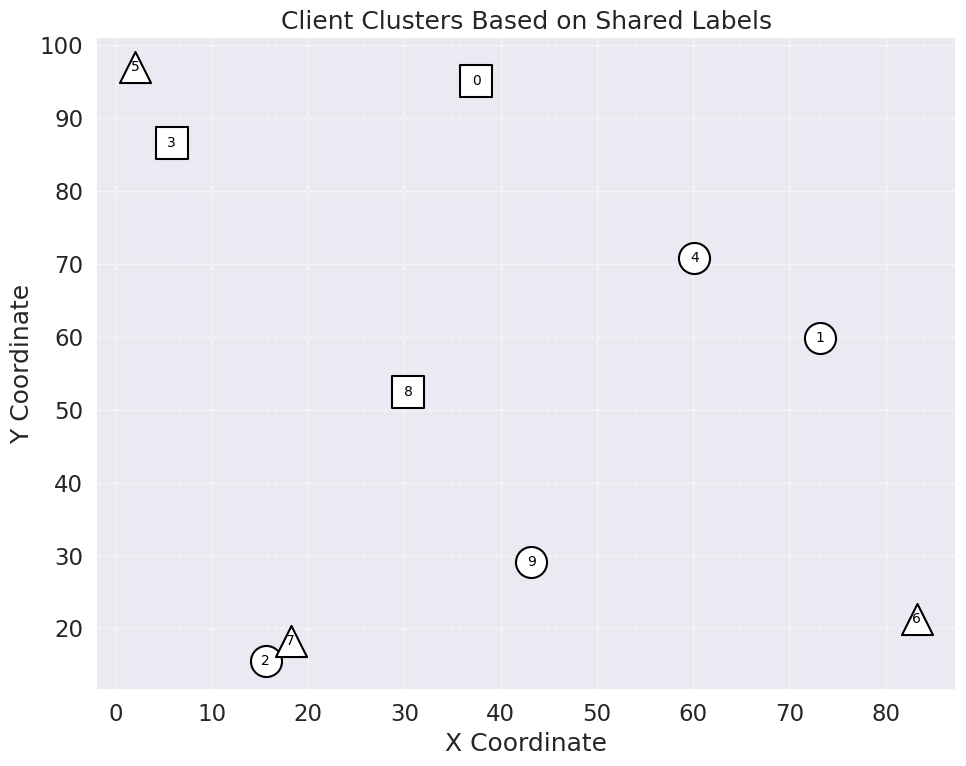

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation

# Step 1: Extract client labels from train_loaders
def extract_client_labels(train_loaders):
    """
    Extract unique labels for each client from their respective train_loader.
    Args:
        train_loaders (list): List of DataLoader objects, one for each client.

    Returns:
        client_labels (dict): Dictionary where keys are client IDs and values are sets of labels.
    """
    client_labels = {}
    for client_id, train_loader in enumerate(train_loaders):
        labels_set = set()
        for _, labels in train_loader:  # Iterate through batches
            labels_set.update(labels.numpy())  # Add labels to the set
        client_labels[client_id] = labels_set
    return client_labels

# Step 2: Compute the similarity matrix
def calculate_similarity_matrix(client_labels):
    """
    Compute a similarity matrix based on the intersection of labels between clients.
    Args:
        client_labels (dict): Dictionary where keys are client IDs and values are sets of labels.

    Returns:
        similarity_matrix (ndarray): A 2D numpy array with similarity scores between clients.
    """
    num_clients = len(client_labels)
    similarity_matrix = np.zeros((num_clients, num_clients))

    for i in range(num_clients):
        for j in range(num_clients):
            if i != j:
                # Compute the number of shared classes (intersection)
                similarity_matrix[i, j] = len(client_labels[i].intersection(client_labels[j]))
            else:
                # Self-similarity (use the size of the client's label set)
                similarity_matrix[i, j] = len(client_labels[i])

    return similarity_matrix

# Step 3: Perform clustering
def cluster_clients(similarity_matrix):
    """
    Cluster clients based on the similarity matrix using Affinity Propagation.
    Args:
        similarity_matrix (ndarray): A 2D numpy array with similarity scores between clients.

    Returns:
        clusters (ndarray): Array of cluster labels for each client.
    """
    clustering = AffinityPropagation(affinity='precomputed', random_state=42)
    clustering.fit(similarity_matrix)
    return clustering.labels_

def plot_clusters(client_labels, clusters):
    """
    Visualize the clusters of clients in a 2D scatter plot with consistent positions,
    cluster-based colors, and readable client IDs.
    Args:
        client_labels (dict): Dictionary of client labels (used to determine the number of clients).
        clusters (ndarray): Array of cluster labels for each client.
    """
    num_clients = len(client_labels)
    np.random.seed(42)  # Set seed for consistent random positions
    points = np.random.rand(num_clients, 2) * 100  # Random 2D points for visualization

    # Plot the clusters
    plt.figure(figsize=(10, 8))
    unique_clusters = np.unique(clusters)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
    markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X']  # Marker styles

    for client_id, cluster_id in enumerate(clusters):
        plt.scatter(
            points[client_id, 0], points[client_id, 1],
            color=colors[cluster_id % len(colors)],
            marker=markers[cluster_id % len(markers)],
            s=500,  # Increase the size of the shapes
            edgecolor="black",
            facecolor="white",  # Add a white background
            linewidth=1.5
        )
        # Annotate with client ID
        plt.text(
            points[client_id, 0], points[client_id, 1],
            str(client_id),  # Client ID
            color="black", fontsize=10, ha="center", va="center"
        )

    # Customize the plot
    plt.title("Client Clusters Based on Shared Labels")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()
# Main execution

# Assuming train_loaders is a list of DataLoader objects, one for each client
# Step 1: Extract client labels
client_labels = extract_client_labels(train_loaders)

# Step 2: Compute the similarity matrix
similarity_matrix = calculate_similarity_matrix(client_labels)

# Step 3: Perform clustering
cluster_labels = cluster_clients(similarity_matrix)

# Step 4: Visualize the clusters
plot_clusters(client_labels, cluster_labels)

# <div style="border-radius:10px; border:#f4af03 solid; padding: 15px; background-color: #506886; font-size:100%; text-align:center">Executing</div>

In [24]:
clusters=[]
initial = [i for i in range(NUMBER_OF_CLIENTS)]
clusters.append(initial)


def generate_initial_models(step,cluster,client_ids,client_Models):
    print("-------------in initial genertaio")
    print("cluster", cluster)
    print("clientIDs", client_ids)
    print("len_client_models(should be 10):",len(client_Models))
    list1=[]

    if step==0:
        for member in range(len(cluster)):
            list1.append(Net())
    else:
        for index in cluster:
            list1.append(client_Models[client_ids.index(index)])
    return list1


client_Models=[]
client_copy_models = []

for step in range(CLUSTERING_PERIOD):
    client_copy_models=copy.deepcopy(client_Models)
    client_Models=[]
    print("\n\n---------Clustering step", step)
    FL_list=[]
    client_ids=[]
    for cluster in clusters:
        for Id in cluster:
            client_ids.append(Id)
        cluster_initial_models=generate_initial_models(step,cluster,client_ids,client_copy_models)
        print(" ---in making new FL----cluster models len:", len(cluster_initial_models),"cluster IDs:", client_ids)
        f = FL(cluster,cluster_initial_models,FEDERATED_LEARNING_ROUNDS, train_loaders, test_loaders, SENSITIVITY_PERCENTAGE)
        FL_list.append(f)
        for member in f.client_obj_list:
            client_Models.append(member.net)
        for cid in client_ids:
            save_torch_model(client_Models[client_ids.index(cid)], cid)
            # save_model_param(client_Models[client_ids.index(cid)], cid, step)
    
    print("----------------------Info before clustering-------------")
    print("model_len:", len(client_Models))
    print("Client IDS:",client_ids )
    start_cluster_time = datetime.now()
    clusters = Clustering(client_ids, train_loaders, SENSITIVITY_PERCENTAGE, CLUSTER_NUMBER).Clusters
    end_cluster_time = datetime.now()
    exe_cluster_time = end_cluster_time - start_cluster_time
    with open(log_file, 'a') as f:
        f.write(f"\n Exe Cluster Time: {exe_cluster_time}")
    print("new clustering:",clusters)



---------Clustering step 0
-------------in initial genertaio
cluster [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
clientIDs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
len_client_models(should be 10): 0
 ---in making new FL----cluster models len: 10 cluster IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
cid is: 0
cid is: 1
cid is: 2
cid is: 3
cid is: 4
cid is: 5
cid is: 6
cid is: 7
cid is: 8
cid is: 9

Round 1/6
_____________________________________________________________________________________________________________
node 0: train_acc: 0.8058666666666666, test_acc:0.87
_____________________________________________________________________________________________________________
node 1: train_acc: 0.6658666666666667, test_acc:0.724
_____________________________________________________________________________________________________________
node 2: train_acc: 0.8042666666666667, test_acc:0.6706666666666666
_____________________________________________________________________________________________________________
node 3